In [9]:
library(tidyverse)
library(rtracklayer)
library(ComplexHeatmap)
suppressPackageStartupMessages(library(ArchR))
library(parallel)
library(viridis)
suppressPackageStartupMessages(library(Seurat))
library(reshape2)
library(rtracklayer)
library(Matrix)
set.seed(1234)

options(repr.matrix.max.cols=300, repr.matrix.max.rows=200)

level = "celltypes"
color_level = "celltype_color"
rpm_cutoff = 5
tissues = c("adrenal", "cortex", "hippocampus", "heart", "gastrocnemius")
min_cells = 100

In [10]:
get_rpm = function(counts_mat){
    df = counts_mat
    df = as.matrix(df)
    sample_totals = colSums(df) # Calculate the total reads in each sample
    scaling_factors = sample_totals / 1000000 # Calculate the "per million" scaling factor for each sample
    df_rpm = sweep(df, 2, scaling_factors, `/`)  # Divide each column by the corresponding scaling factor to get RPM
    return(df_rpm)

}

# Get metadata

In [3]:
meta = read.csv("../snatac/ref/enc4_mouse_snatac_metadata.csv")
sex_palette = c("Male" = "blue", "Female" = "pink")
tp_palette = c('PND_14' = '#ec80eb',
               'PNM_02' = '#800080')
tissue_palette = c('Adrenal' = '#ff9458',
                   'Cortex' =  '#ffe578',
                   'Hippocampus' = '#967add',
                   'Gastrocnemius' = '#34b0d8',
                   'Heart' = '#ff9aaf')

annot_cols = read.csv("../snrna/ref/enc4_mouse_snrna_celltypes.csv")
annot_cols$tissue =  tolower(annot_cols$tissue)


# Get pseudobulk RPM matrix across all clusters in all tissues

In [4]:
tissue_cluster_df_list = list()
cluster_annotation_map = list()

In [5]:
for (tissue in tissues) {
    print(tissue)
    meta = read.csv(paste0("../snrna/",tissue,"/seurat/",tissue,"_10x_metadata.csv"))

    # sub.cluster instead of cluster was used to annotate in a few tissues (i.e. in HC needed to split neurotrans. GABA subtypes)
    if ("sub.cluster" %in% colnames(meta)){  
        cluster_annotation_map[[tissue]] = unique(meta[,c("archr_cellID","seurat_clusters","sub.cluster","gen_celltype","celltypes","subtypes")])
        cluster_annotation_map[[tissue]]$seurat_clusters = cluster_annotation_map[[tissue]]$sub.cluster
        cluster_annotation_map[[tissue]]$sub.cluster = NULL
    } else {
        cluster_annotation_map[[tissue]] = unique(meta[,c("archr_cellID","seurat_clusters","gen_celltype","celltypes","subtypes")])
    }

    # load Archr proj
    path = paste0("../snatac/",tissue,"/archr/ENC4_Mouse_",str_to_title(tissue))
    proj = loadArchRProject(path = paste0(path,"/"))

    # get cCRE counts, default options
    proj_mat = getMatrixFromProject(proj, useMatrix = "PeakMatrix")
    proj_mat = assay(proj_mat) # extract matrix

    clusters = as.character(unique(cluster_annotation_map[[tissue]]$seurat_clusters)) ### USE RNA CLUSTERS
    pbulk_cluster_list = list()

    for (cluster in clusters) {
        # subset project for the cluster
        # use metadata from before
        cluster_annotation_map_thiscluster = cluster_annotation_map[[tissue]]
        cluster_annotation_map_thiscluster= cluster_annotation_map_thiscluster[cluster_annotation_map_thiscluster$seurat_clusters == cluster,]
        cellsSample = cluster_annotation_map_thiscluster$archr_cellID

        pbulk_mat = proj_mat[,colnames(proj_mat) %in% cellsSample]
        
        # actually pseudobulk
        pbulk_cluster_list[[cluster]] = rowSums(pbulk_mat) # sum up column for each cell across the cluster


    }

    peaks = as.data.frame(getPeakSet(proj)) # extract cCRE peak set from archr
    peaks$peakID = paste0(peaks$seqnames,"_",peaks$start,"_",peaks$end) # make peakID

    pbulk_cluster_mat = do.call(cbind, pbulk_cluster_list) # all clusters per tissue
    rownames(pbulk_cluster_mat) = peaks$peakID 
    
    tissue_cluster_df_list[[tissue]] = pbulk_cluster_mat # all clusters per tissue in a big list

    cluster_annotation_map[[tissue]]$archr_cellID = NULL
    cluster_annotation_map[[tissue]] = unique(cluster_annotation_map[[tissue]])
    cluster_annotation_map[[tissue]]$tissue = tissue

}

[1] "adrenal"


Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

[1] "cortex"


Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

[1] "hippocampus"


Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

[1] "heart"


Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

[1] "gastrocnemius"


Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [6]:
tissue_cluster_counts_all = do.call(cbind.data.frame, tissue_cluster_df_list) # make 1 big counts matrix at the cluster level
tissue_cluster_counts_all = as.matrix(tissue_cluster_counts_all)
head(tissue_cluster_counts_all)
write.csv(tissue_cluster_counts_all, file="data/fig4_archr_tissue_cluster_pseudobulk_counts.csv")



,adrenal.1,adrenal.25,adrenal.17,adrenal.7,adrenal.16,adrenal.0,adrenal.4,adrenal.5,adrenal.2,adrenal.8,adrenal.15,adrenal.3,adrenal.6,adrenal.23,adrenal.30,adrenal.21,adrenal.28,adrenal.19,adrenal.11,adrenal.27,adrenal.18,adrenal.12,adrenal.14,adrenal.22,adrenal.32,adrenal.20,adrenal.10,adrenal.9,adrenal.26,adrenal.24,adrenal.29,adrenal.13,cortex.6,cortex.15,cortex.22,cortex.1,cortex.14,cortex.0,cortex.3,cortex.7,cortex.10,cortex.23,cortex.20,cortex.5,cortex.8,cortex.9,cortex.2,cortex.4,cortex.27,cortex.32,cortex.17,cortex.29,cortex.26,cortex.25,cortex.11,cortex.13,cortex.16,cortex.19,cortex.12,cortex.30,cortex.24,cortex.33,cortex.35,cortex.31,cortex.34,cortex.21,cortex.38,cortex.39,cortex.36,cortex.18,cortex.28,cortex.37,hippocampus.15,hippocampus.1,hippocampus.12,hippocampus.0,hippocampus.18,hippocampus.2,hippocampus.8,hippocampus.22_0,hippocampus.10_0,hippocampus.6,hippocampus.14,hippocampus.5,hippocampus.4,hippocampus.3,hippocampus.20,hippocampus.17,hippocampus.23,hippocampus.13,hippocampus.9,hippocampus.10_1,hippocampus.19,hippocampus.26,hippocampus.7,hippocampus.16_1,hippocampus.21,hippocampus.11,hippocampus.30,hippocampus.16_0,hippocampus.35,hippocampus.31,hippocampus.27,hippocampus.28,hippocampus.29,hippocampus.34,hippocampus.33,hippocampus.24,hippocampus.32,hippocampus.25,hippocampus.22_1,heart.9,heart.0,heart.2,heart.11,heart.26,heart.5,heart.13,heart.3,heart.7,heart.14,heart.8,heart.4,heart.12,heart.16,heart.15,heart.24,heart.27,heart.19,heart.10,heart.20,heart.21,heart.18,heart.6,heart.1,heart.17,heart.22,heart.25,heart.23,heart.28,gastrocnemius.1,gastrocnemius.3,gastrocnemius.42,gastrocnemius.21,gastrocnemius.12,gastrocnemius.26,gastrocnemius.11,gastrocnemius.17,gastrocnemius.16,gastrocnemius.41,gastrocnemius.35,gastrocnemius.10,gastrocnemius.19,gastrocnemius.37,gastrocnemius.22,gastrocnemius.23,gastrocnemius.2,gastrocnemius.15,gastrocnemius.34,gastrocnemius.32,gastrocnemius.27,gastrocnemius.33,gastrocnemius.30,gastrocnemius.25_0,gastrocnemius.20,gastrocnemius.44,gastrocnemius.18,gastrocnemius.39,gastrocnemius.31,gastrocnemius.28,gastrocnemius.5,gastrocnemius.7,gastrocnemius.13,gastrocnemius.6,gastrocnemius.29,gastrocnemius.38,gastrocnemius.45,gastrocnemius.43,gastrocnemius.25_1,gastrocnemius.4,gastrocnemius.24,gastrocnemius.36,gastrocnemius.14,gastrocnemius.8,gastrocnemius.9,gastrocnemius.0,gastrocnemius.40
chr1_3012682_3012836,1,0,0,1,0,3,2,1,1,4,2,2,2,0,0,2,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,10,1,2,10,0,16,1,3,6,2,3,6,2,2,5,9,0,0,0,1,1,0,3,0,4,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,36,0,25,7,3,11,4,0,4,0,28,21,25,1,1,0,7,28,0,3,3,31,0,0,1,0,0,0,0,0,0,0,1,0,0,1,2,0,4,29,8,1,0,5,1,0,2,5,1,12,1,1,3,0,0,0,0,0,1,0,2,26,0,0,0,0,0,1,1,0,0,1,0,0,4,0,0,3,0,1,0,0,0,1,0,0,2,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
chr1_3035822_3035995,1,0,0,1,0,1,0,1,0,0,0,0,3,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,2,0,2,0,1,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,0,1,0,0,1,0,0,2,2,0,1,0,0,0,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,1,1,0,2,1,6,1,1,0,4,0,0,0,0,0,0,2,0,0,0,4,6,0,1,0,0,0,0,2,0,0,0,4,0,0,3,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
chr1_3059628_3059790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3062548_3062749,2,0,2,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,2,1,0,0,4,6,1,2,3,0,2,2,1,0,1,1,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,1,1,3,2,1,0,0,0,0,0,4,0,1,2,0,0,0,4,2,0,0,3,0,0,1,0,1,0,0,0,0,1,0,2,0,0,0,0,0,4,1,1,0,0,0,0,0,0,0,3,0,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0
chr1_3062790_3063138,4,0,3,0,0,2,1,0,1,0,1

In [7]:
cluster_annotation_map_all = do.call(rbind, cluster_annotation_map)
rownames(cluster_annotation_map_all) = NULL
head(cluster_annotation_map_all)
write.csv(cluster_annotation_map_all, file="data/fig4_archr_tissue_cluster_annotation_map.csv")



,seurat_clusters,gen_celltype,celltypes,subtypes,tissue
,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,Cortex,Cortex,Cortex_ZF,adrenal
2,25,Endothelial,Endothelial,Endothelial_cycling,adrenal
3,17,Cortex,Cortex,Cortex_cycling,adrenal
4,7,Adipocyte,Adipocyte,Adipocyte,adrenal
5,16,Immune,Macrophage,Macrophage,adrenal
6,0,Cortex,Cortex,Cortex_ZG,adrenal


# Calculate binary matrix based on cluster level

## Calculate RPM

In [8]:
tissue_cluster_counts_all = read.csv("data/fig4_archr_tissue_cluster_pseudobulk_counts.csv", row.names="X")


In [11]:
tissue_cluster_rpm_mat = get_rpm(tissue_cluster_counts_all)
binary_ccres = tissue_cluster_rpm_mat
nrow(binary_ccres)
binary_ccres[binary_ccres < rpm_cutoff] = 0
binary_ccres[binary_ccres >= rpm_cutoff] = 1

binary_ccres = binary_ccres[rowSums(binary_ccres) > 0,]

print(paste0(nrow(binary_ccres), " cCREs in tissue after filtering / binarizing"))


[1] 926843

[1] "502200 cCREs in tissue after filtering / binarizing"


In [12]:
head(binary_ccres)

,adrenal.1,adrenal.25,adrenal.17,adrenal.7,adrenal.16,adrenal.0,adrenal.4,adrenal.5,adrenal.2,adrenal.8,adrenal.15,adrenal.3,adrenal.6,adrenal.23,adrenal.30,adrenal.21,adrenal.28,adrenal.19,adrenal.11,adrenal.27,adrenal.18,adrenal.12,adrenal.14,adrenal.22,adrenal.32,adrenal.20,adrenal.10,adrenal.9,adrenal.26,adrenal.24,adrenal.29,adrenal.13,cortex.6,cortex.15,cortex.22,cortex.1,cortex.14,cortex.0,cortex.3,cortex.7,cortex.10,cortex.23,cortex.20,cortex.5,cortex.8,cortex.9,cortex.2,cortex.4,cortex.27,cortex.32,cortex.17,cortex.29,cortex.26,cortex.25,cortex.11,cortex.13,cortex.16,cortex.19,cortex.12,cortex.30,cortex.24,cortex.33,cortex.35,cortex.31,cortex.34,cortex.21,cortex.38,cortex.39,cortex.36,cortex.18,cortex.28,cortex.37,hippocampus.15,hippocampus.1,hippocampus.12,hippocampus.0,hippocampus.18,hippocampus.2,hippocampus.8,hippocampus.22_0,hippocampus.10_0,hippocampus.6,hippocampus.14,hippocampus.5,hippocampus.4,hippocampus.3,hippocampus.20,hippocampus.17,hippocampus.23,hippocampus.13,hippocampus.9,hippocampus.10_1,hippocampus.19,hippocampus.26,hippocampus.7,hippocampus.16_1,hippocampus.21,hippocampus.11,hippocampus.30,hippocampus.16_0,hippocampus.35,hippocampus.31,hippocampus.27,hippocampus.28,hippocampus.29,hippocampus.34,hippocampus.33,hippocampus.24,hippocampus.32,hippocampus.25,hippocampus.22_1,heart.9,heart.0,heart.2,heart.11,heart.26,heart.5,heart.13,heart.3,heart.7,heart.14,heart.8,heart.4,heart.12,heart.16,heart.15,heart.24,heart.27,heart.19,heart.10,heart.20,heart.21,heart.18,heart.6,heart.1,heart.17,heart.22,heart.25,heart.23,heart.28,gastrocnemius.1,gastrocnemius.3,gastrocnemius.42,gastrocnemius.21,gastrocnemius.12,gastrocnemius.26,gastrocnemius.11,gastrocnemius.17,gastrocnemius.16,gastrocnemius.41,gastrocnemius.35,gastrocnemius.10,gastrocnemius.19,gastrocnemius.37,gastrocnemius.22,gastrocnemius.23,gastrocnemius.2,gastrocnemius.15,gastrocnemius.34,gastrocnemius.32,gastrocnemius.27,gastrocnemius.33,gastrocnemius.30,gastrocnemius.25_0,gastrocnemius.20,gastrocnemius.44,gastrocnemius.18,gastrocnemius.39,gastrocnemius.31,gastrocnemius.28,gastrocnemius.5,gastrocnemius.7,gastrocnemius.13,gastrocnemius.6,gastrocnemius.29,gastrocnemius.38,gastrocnemius.45,gastrocnemius.43,gastrocnemius.25_1,gastrocnemius.4,gastrocnemius.24,gastrocnemius.36,gastrocnemius.14,gastrocnemius.8,gastrocnemius.9,gastrocnemius.0,gastrocnemius.40
chr1_3094795_3095138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3095147_3095347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3119618_3119911,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3119915_3120119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3120347_3120662,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Remove small clusters

In [13]:
ncells_per_cluster = list()

for (this_tissue in tissues) {
    meta = read.csv(paste0("../snrna/",this_tissue,"/seurat/",this_tissue,"_10x_metadata.csv"))

    if ("sub.cluster" %in% colnames(meta)){  
        meta = unique(meta[,c("archr_cellID","seurat_clusters","sub.cluster","subtypes","celltypes","gen_celltype")])
        meta$seurat_clusters = meta$sub.cluster
        meta$sub.cluster = NULL

    } else {
        meta = unique(meta[,c("archr_cellID","seurat_clusters","subtypes","celltypes","gen_celltype")])
    }
    
    ncells_per_cluster[[this_tissue]] = data.frame(table(meta$seurat_clusters))
    colnames(ncells_per_cluster[[this_tissue]]) = c("group","n_cells")
    ncells_per_cluster[[this_tissue]]$tissue = this_tissue
    ncells_per_cluster[[this_tissue]]$tissue_cluster = paste0(ncells_per_cluster[[this_tissue]]$tissue,".",ncells_per_cluster[[this_tissue]]$group)
}


In [14]:
ncells_per_cluster_filter = do.call(rbind.data.frame, ncells_per_cluster)
ncells_per_cluster_filter = ncells_per_cluster_filter[ncells_per_cluster_filter$n_cells < min_cells, ]
ncells_per_cluster_filter

filter = ncells_per_cluster_filter$tissue_cluster


,group,n_cells,tissue,tissue_cluster
,<fct>,<int>,<chr>,<chr>
adrenal.27,26,16,adrenal,adrenal.26
adrenal.28,27,56,adrenal,adrenal.27
adrenal.29,28,68,adrenal,adrenal.28
adrenal.30,29,2,adrenal,adrenal.29
adrenal.31,30,15,adrenal,adrenal.30
adrenal.32,32,14,adrenal,adrenal.32
cortex.29,28,4,cortex,cortex.28
heart.24,23,16,heart,heart.23
heart.26,25,91,heart,heart.25


In [15]:
binary_ccres = binary_ccres[, !(colnames(binary_ccres) %in% filter)]
binary_ccres = binary_ccres[rowSums(binary_ccres) > 0,]


In [16]:
nrow(binary_ccres) # final # of clusters across tissues = 173

[1] 390146

## Also filter small clusters from metadata

In [19]:
cluster_annotation_map_all = read.csv("data/fig4_archr_tissue_cluster_annotation_map.csv", row.names="X")

cluster_annotation_map_all$tissue_cluster = paste0(cluster_annotation_map_all$tissue,".",
                                                   cluster_annotation_map_all$seurat_clusters)
cluster_annotation_map_all$tissue_celltype = paste0(cluster_annotation_map_all$tissue,".",
                                                    cluster_annotation_map_all[[level]])

cluster_annotation_map_all = cluster_annotation_map_all[!(cluster_annotation_map_all$tissue_cluster %in% filter),]

cluster_annotation_map_all = cluster_annotation_map_all[match(colnames(binary_ccres),
                                                             cluster_annotation_map_all$tissue_cluster),]

table(colnames(binary_ccres) == cluster_annotation_map_all$tissue_cluster)


TRUE 
 173 

In [20]:
head(cluster_annotation_map_all)

,seurat_clusters,gen_celltype,celltypes,subtypes,tissue,tissue_cluster,tissue_celltype
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,Cortex,Cortex,Cortex_ZF,adrenal,adrenal.1,adrenal.Cortex
2,25,Endothelial,Endothelial,Endothelial_cycling,adrenal,adrenal.25,adrenal.Endothelial
3,17,Cortex,Cortex,Cortex_cycling,adrenal,adrenal.17,adrenal.Cortex
4,7,Adipocyte,Adipocyte,Adipocyte,adrenal,adrenal.7,adrenal.Adipocyte
5,16,Immune,Macrophage,Macrophage,adrenal,adrenal.16,adrenal.Macrophage
6,0,Cortex,Cortex,Cortex_ZG,adrenal,adrenal.0,adrenal.Cortex


# Check cCRE accessibility per celltype
By using the cluster-level matrix, and annotation mapping cluster to celltype

In [21]:
tissue_type_binary = data.frame(matrix(ncol = length(unique(cluster_annotation_map_all$tissue_celltype)), 
                                           nrow = nrow(binary_ccres)))

# for each cluster, get the associated celltype
for (i in 1:length(unique(cluster_annotation_map_all$tissue_celltype))){
    tissue_celltype = unique(cluster_annotation_map_all$tissue_celltype)[i]
    
    
    celltype_clusters = cluster_annotation_map_all[cluster_annotation_map_all$tissue_celltype == tissue_celltype,]
    binary_ccres_this_celltype = binary_ccres[,colnames(binary_ccres) %in% celltype_clusters$tissue_cluster]

    # if only 1 corresponding cluster, fill in that one vector
    if (is.vector(binary_ccres_this_celltype)){
        tissue_type_binary[,i] = binary_ccres_this_celltype
    } else {
        # else, sum up # of accessible cCREs
        tissue_type_binary[,i] = rowSums(binary_ccres_this_celltype)
        
    }    
} 
colnames(tissue_type_binary) = unique(cluster_annotation_map_all$tissue_celltype)
rownames(tissue_type_binary) = rownames(binary_ccres)

# re-calculate binary matrix
tissue_type_binary[tissue_type_binary <1 ] = 0
tissue_type_binary[tissue_type_binary >= 1] = 1


In [22]:
head(tissue_type_binary)

,adrenal.Cortex,adrenal.Endothelial,adrenal.Adipocyte,adrenal.Macrophage,adrenal.Medulla,adrenal.Stromal,adrenal.Fibroblast,adrenal.Sox10,cortex.Glutamatergic,cortex.GABAergic,cortex.Astrocyte,cortex.OPC,cortex.VLMC,cortex.Endothelial,cortex.Oligodendrocyte,cortex.Microglia,cortex.Pericyte,hippocampus.Oligodendrocyte,hippocampus.Glutamatergic,hippocampus.Microglia,hippocampus.Astrocyte,hippocampus.GABAergic,hippocampus.OPC,hippocampus.Endothelial,hippocampus.Pericyte,hippocampus.VLMC,hippocampus.Ependymal,heart.Fibroblast,heart.Cardiomyocyte,heart.Macrophage,heart.Pericyte,heart.Endothelial,heart.Endocardial,heart.Epicardial,heart.Schwann,heart.Smooth_muscle,heart.Lymphatic_endothelial,heart.Lymphocyte,gastrocnemius.Myonuclei,gastrocnemius.Tenocyte,gastrocnemius.FAP,gastrocnemius.Endothelial,gastrocnemius.Schwann,gastrocnemius.Smooth_muscle,gastrocnemius.Lymphocyte,gastrocnemius.Macrophage,gastrocnemius.Adipocyte
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1_3094795_3095138,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3095147_3095347,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3119618_3119911,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
chr1_3119915_3120119,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
chr1_3120347_3120662,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
chr1_3121353_3121682,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [23]:
saveRDS(tissue_type_binary, file=paste0("data/fig4_tissue_type_binary_",level,".rds"))

# Classification of cCREs within each tissue


In [24]:
ncells_per_group_list = list()
for (this_tissue in tissues){
    # get major and minor cell types
    meta = read.csv(paste0("../snrna/",this_tissue,"/seurat/",this_tissue,"_10x_metadata.csv"))
    ncells_per_group = data.frame(table(meta[[level]]))
    colnames(ncells_per_group) = c("group","n_cells")
    ncells_per_group = ncells_per_group[order(ncells_per_group$n_cells, decreasing = TRUE),]
    ncells_per_group$cumul_pct = (cumsum(ncells_per_group$n_cells) / nrow(meta))*100
    #print(nrow(meta))
    #print(ncells_per_group)
    ncells_per_group_list[[this_tissue]] = ncells_per_group
}



In [25]:
ncells_per_group_all = do.call(rbind, ncells_per_group_list)
ncells_per_group_all$cumul_pct = NULL
rownames(ncells_per_group_all) = NULL

ncells_per_group_all_sum = aggregate(n_cells ~ group, data = ncells_per_group_all, sum)

ncells_per_group_all_sum = ncells_per_group_all_sum[order(ncells_per_group_all_sum$n_cells, decreasing = TRUE),]
ncells_per_group_all_sum$cumul_pct = (cumsum(ncells_per_group_all_sum$n_cells)  / (34999+63978+36222+58927+42934))*100

#head(ncells_per_group_all_sum,9)

logical_vector = ncells_per_group_all_sum$cumul_pct < 90
result = logical_vector | c(FALSE, head(logical_vector, -1))
major_types_all = as.character(ncells_per_group_all_sum$group[result])
print("Major celltypes across all tissues:")
print(major_types_all)



[1] "Major celltypes across all tissues:"
 [1] "Glutamatergic"   "Myonuclei"       "Endothelial"     "Cortex"         
 [5] "Cardiomyocyte"   "Fibroblast"      "GABAergic"       "Astrocyte"      
 [9] "FAP"             "Oligodendrocyte" "OPC"             "Macrophage"     
[13] "Microglia"      


In [26]:
tissue_type_binary_collapsed = as.data.frame(tissue_type_binary[rowSums(tissue_type_binary) > length(major_types_all),])
group_names = do.call("rbind", strsplit(colnames(tissue_type_binary_collapsed), "[.]"))[,2]
group_names = unique(group_names)

collaped_final_df = as.data.frame(matrix(NA, nrow = nrow(tissue_type_binary_collapsed), ncol = length(group_names)))
colnames(collaped_final_df) = unique(group_names)
rownames(collaped_final_df) = rownames(tissue_type_binary_collapsed)

# Loop through unique column names and sum up columns with similar names
for (i in 1:length(group_names)) {
    group_name = group_names[i]
    matches = grep(group_name, colnames(tissue_type_binary_collapsed))
    if (length(matches) > 1){
        dupes = tissue_type_binary_collapsed[, grep(group_name, colnames(tissue_type_binary_collapsed))]
        collaped_final_df[[group_name]] = rowSums(dupes)    
    } else {
        collaped_final_df[[group_name]] = tissue_type_binary_collapsed[,grep(group_name, colnames(tissue_type_binary_collapsed))]
    }
}


In [27]:
collaped_final_df_major = collaped_final_df[, colnames(collaped_final_df) %in% major_types_all]
FINALLY_global = rownames(collaped_final_df)[(apply(collaped_final_df, 1, function(row) all(row >= 1)))]


In [28]:
ccre_breakdown = list()
specific_ccre_list = list()
shared_ccre_list = list()
general_ccre_list = list()
binary_ccres_list = list()

for (this_tissue in tissues){ 
    ncells_per_group = ncells_per_group_list[[this_tissue]]
    
    # find out major celltypes from snrna metadata
    logical_vector = ncells_per_group$cumul_pct < 90
    result = logical_vector | c(FALSE, head(logical_vector, -1))
    major_types = as.character(ncells_per_group$group[result])
    #print(paste0("Major celltypes in ",this_tissue,":"))
    #print(major_types)

    # subset each tissue
    binary_ccres_list[[this_tissue]] = tissue_type_binary[,grep(this_tissue, colnames(tissue_type_binary))]
    colnames(binary_ccres_list[[this_tissue]]) = gsub(paste0(this_tissue,"."),"",colnames(binary_ccres_list[[this_tissue]]))

    # get ccre breakdown -- types, global, and shared
    specific_ccre_list[[this_tissue]] = binary_ccres_list[[this_tissue]][rowSums(binary_ccres_list[[this_tissue]]) == 1,]
    
    shared_ccre_list[[this_tissue]] = binary_ccres_list[[this_tissue]][rowSums(binary_ccres_list[[this_tissue]]) > 1,] # anything > 1 is either shared or general

    major_type_mat = shared_ccre_list[[this_tissue]][,colnames(shared_ccre_list[[this_tissue]]) %in% major_types]
    general_ccre_list[[this_tissue]] = shared_ccre_list[[this_tissue]][rowSums(major_type_mat) == ncol(major_type_mat),] # sum of columns is same as number of major cell types
    shared_ccre_list[[this_tissue]] = shared_ccre_list[[this_tissue]][!(rownames(shared_ccre_list[[this_tissue]]) %in% rownames(general_ccre_list[[this_tissue]])),] # reverse subset the shared cCREs df

    ccre_breakdown[[this_tissue]] = data.frame(colSums(specific_ccre_list[[this_tissue]]))
    colnames(ccre_breakdown[[this_tissue]]) = "n_ccres_rpm_cutoff"
    ccre_breakdown[[this_tissue]]$group = rownames(ccre_breakdown[[this_tissue]])
    rownames(ccre_breakdown[[this_tissue]]) = NULL

    ccre_breakdown[[this_tissue]] = rbind(ccre_breakdown[[this_tissue]], c(nrow(general_ccre_list[[this_tissue]]), "Global"))
    ccre_breakdown[[this_tissue]] = rbind(ccre_breakdown[[this_tissue]], c(nrow(shared_ccre_list[[this_tissue]]), "Shared"))
    ccre_breakdown[[this_tissue]][,1] = as.numeric(ccre_breakdown[[this_tissue]][,1])
    ccre_breakdown[[this_tissue]]$tissue = rep(this_tissue, nrow(ccre_breakdown[[this_tissue]]))    
          
          
          
}


# Final classifications based on all tissues

Rules for categories - 

- If it's specific in 1 tissue but shared in another, we'll call it "shared" overall.
- If it's specific in 1 tissue but general in another, we'll call it "general" overall.
- If it's shared in 1 tissue but general in another, we'll call it "general" overall.
- If it's in all major types across tissues, we'll call it "global" overall.

In [29]:
specific_ccres_list_alltissues = list()
shared_ccres_list_alltissues = list()
general_ccres_list_alltissues = list()

tissues = c("adrenal", "cortex", "hippocampus", "heart", "gastrocnemius")

for (tissue in tissues){

    specific_ccres_list_alltissues[[tissue]] = rownames(specific_ccre_list[[tissue]])
    shared_ccres_list_alltissues[[tissue]] = rownames(shared_ccre_list[[tissue]])
    general_ccres_list_alltissues[[tissue]] = rownames(general_ccre_list[[tissue]])
    
}

specific_ccres_alltissues = unique(do.call(c, specific_ccres_list_alltissues))
shared_ccres_alltissues = unique(do.call(c, shared_ccres_list_alltissues))
general_ccres_alltissues = unique(do.call(c, general_ccres_list_alltissues))


# If it's specific in 1 tissue but shared in another, we'll call it "shared" overall.
specific_ccres_alltissues_final = specific_ccres_alltissues[!(specific_ccres_alltissues %in% shared_ccres_alltissues)]

# If it's specific in 1 tissue but general in another, we'll call it "general" overall.
specific_ccres_alltissues_final = specific_ccres_alltissues_final[!(specific_ccres_alltissues_final %in% general_ccres_alltissues)]

# If it's shared in 1 tissue but general in another, we'll call it "general" overall.
shared_ccres_alltissues_final = shared_ccres_alltissues[!(shared_ccres_alltissues %in% general_ccres_alltissues)]

general_ccres_alltissues_final =  general_ccres_alltissues[!(general_ccres_alltissues %in% FINALLY_global)]
global_ccres_alltissues_final = FINALLY_global


# Associate celltypes with the cCREs classified as celltype specific 

In [30]:
specific_ccres_df_alltissues_celltypes = list()

tissues = c("adrenal", "cortex", "hippocampus", "heart", "gastrocnemius")

for (tissue in tissues){

    specific_ccres_df_alltissues_celltypes[[tissue]] = as.data.frame(rownames(specific_ccre_list[[tissue]]))
    colnames(specific_ccres_df_alltissues_celltypes[[tissue]]) = "name"
    specific_ccres_df_alltissues_celltypes[[tissue]]$tissue = tissue
    specific_ccres_df_alltissues_celltypes[[tissue]]$category = "specific"
    specific_ccres_df_alltissues_celltypes[[tissue]]$celltype = colnames(specific_ccre_list[[tissue]])[apply(specific_ccre_list[[tissue]] == 1, 1, which)]
    specific_ccres_df_alltissues_celltypes[[tissue]]$tissue_celltype = paste0(tissue,".",specific_ccres_df_alltissues_celltypes[[tissue]]$celltype)
    
    specific_ccres_df_alltissues_celltypes[[tissue]] = specific_ccres_df_alltissues_celltypes[[tissue]][specific_ccres_df_alltissues_celltypes[[tissue]]$name %in% specific_ccres_alltissues_final,]

    
}


In [31]:
specific_ccres_df_alltissues_celltypes_final = do.call(rbind.data.frame, specific_ccres_df_alltissues_celltypes)


all_tissue_celltypes = unique(specific_ccres_df_alltissues_celltypes_final$tissue_celltype) 

specific_tissue_celltypes_ccres = list()

for (tissue_celltype in all_tissue_celltypes) {
    specific_tissue_celltypes_ccres[[tissue_celltype]] = specific_ccres_df_alltissues_celltypes_final[specific_ccres_df_alltissues_celltypes_final$tissue_celltype == tissue_celltype,"name"]
    
    
}

table(specific_ccres_df_alltissues_celltypes_final$tissue_celltype)


          adrenal.Adipocyte              adrenal.Cortex 
                       8043                       24429 
        adrenal.Endothelial          adrenal.Fibroblast 
                       5495                        2643 
         adrenal.Macrophage             adrenal.Medulla 
                       4129                        5804 
              adrenal.Sox10             adrenal.Stromal 
                       1583                        1936 
           cortex.Astrocyte          cortex.Endothelial 
                       1834                        1665 
           cortex.GABAergic        cortex.Glutamatergic 
                       9507                       32227 
           cortex.Microglia                  cortex.OPC 
                      13068                        1716 
     cortex.Oligodendrocyte             cortex.Pericyte 
                       5267                        4138 
                cortex.VLMC     gastrocnemius.Adipocyte 
                       4527   

In [32]:
# Count occurrences of each name across cell types
name_counts <- specific_ccres_df_alltissues_celltypes_final %>%
  group_by(name) %>%
  dplyr::summarise(celltype_count = n_distinct(celltype))

# Identify names specific to only one cell type
unique_names <- name_counts$name[name_counts$celltype_count == 1]

# Identify names associated with more than one cell type
shared_names <- name_counts$name[name_counts$celltype_count > 1]

head(tissue_type_binary[rownames(tissue_type_binary) %in% shared_names, ])


# Display the results
print("cCREs Specific to Only One Cell Type across tissues:")
print(length(unique_names))

print("cCREs Associated with More Than One Cell Type across tissues:")
print(length(shared_names))

specific_ccres_alltissues_final_FINAL = specific_ccres_alltissues_final[specific_ccres_alltissues_final %in% unique_names]
shared_ccres_alltissues_final_FINAL = c(shared_ccres_alltissues_final, shared_names)

general_ccres_alltissues_final_FINAL = general_ccres_alltissues_final

global_ccres_alltissues_final_FINAL = global_ccres_alltissues_final

,adrenal.Cortex,adrenal.Endothelial,adrenal.Adipocyte,adrenal.Macrophage,adrenal.Medulla,adrenal.Stromal,adrenal.Fibroblast,adrenal.Sox10,cortex.Glutamatergic,cortex.GABAergic,cortex.Astrocyte,cortex.OPC,cortex.VLMC,cortex.Endothelial,cortex.Oligodendrocyte,cortex.Microglia,cortex.Pericyte,hippocampus.Oligodendrocyte,hippocampus.Glutamatergic,hippocampus.Microglia,hippocampus.Astrocyte,hippocampus.GABAergic,hippocampus.OPC,hippocampus.Endothelial,hippocampus.Pericyte,hippocampus.VLMC,hippocampus.Ependymal,heart.Fibroblast,heart.Cardiomyocyte,heart.Macrophage,heart.Pericyte,heart.Endothelial,heart.Endocardial,heart.Epicardial,heart.Schwann,heart.Smooth_muscle,heart.Lymphatic_endothelial,heart.Lymphocyte,gastrocnemius.Myonuclei,gastrocnemius.Tenocyte,gastrocnemius.FAP,gastrocnemius.Endothelial,gastrocnemius.Schwann,gastrocnemius.Smooth_muscle,gastrocnemius.Lymphocyte,gastrocnemius.Macrophage,gastrocnemius.Adipocyte
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1_3167135_3167466,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
chr1_3210258_3210606,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3212684_3213018,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3407394_3407710,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3447359_3447707,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr1_3514872_3515202,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


[1] "cCREs Specific to Only One Cell Type across tissues:"
[1] 168443
[1] "cCREs Associated with More Than One Cell Type across tissues:"
[1] 51708


# Fig. 4a


[1] 43.17435

[1] 47.88079

[1] 5.463083

[1] 3.481773

category,value
<chr>,<int>
Specific in celltypes,168443
Shared,186805
General,21314
Global,13584


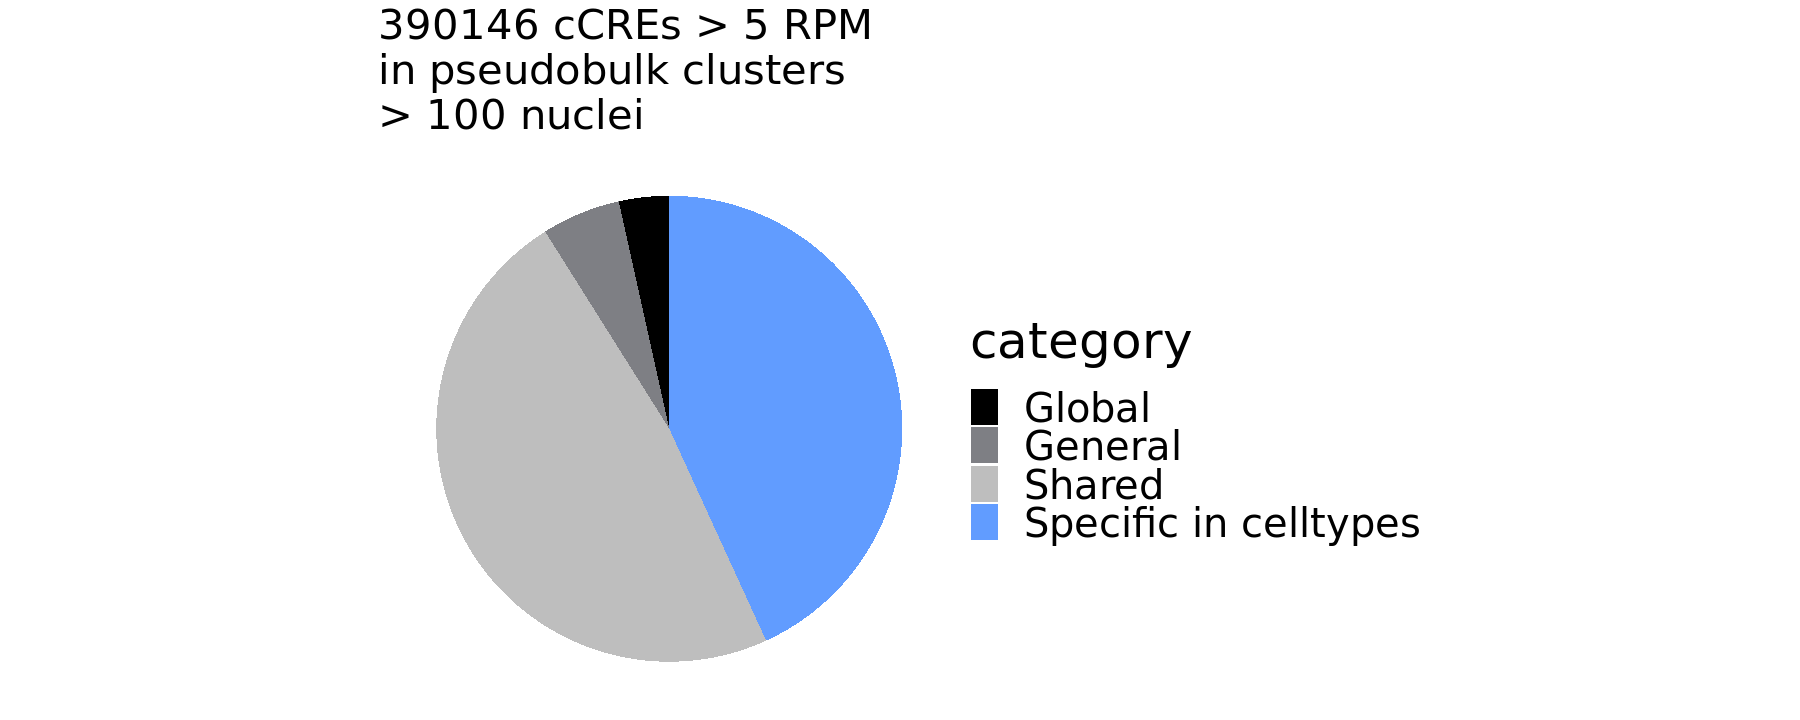

In [35]:
tot_ccres = length(specific_ccres_alltissues_final_FINAL) +  
    length(shared_ccres_alltissues_final_FINAL) +
    length(general_ccres_alltissues_final_FINAL) +
    length(global_ccres_alltissues_final_FINAL)
    

(length(specific_ccres_alltissues_final_FINAL) / tot_ccres)*100
(length(shared_ccres_alltissues_final_FINAL)/ tot_ccres)*100
(length(general_ccres_alltissues_final_FINAL)/ tot_ccres)*100
(length(global_ccres_alltissues_final_FINAL)/ tot_ccres)*100

piedata <- data.frame(
  category = c(paste0("Specific in ",level), "Shared", "General","Global"),
  value = c(length(specific_ccres_alltissues_final_FINAL), 
            length(shared_ccres_alltissues_final_FINAL), 
            length(general_ccres_alltissues_final_FINAL),
            length(global_ccres_alltissues_final_FINAL))
)
piedata
options(repr.plot.width = 15, repr.plot.height = 6)

piedata$category = factor(piedata$category, levels = c("Global","General","Shared",paste0("Specific in ",level)))
ggplot(piedata, aes(x = "", y = value, fill = category)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar(theta = "y") + 
  theme_void() + ggtitle(paste0(tot_ccres," cCREs > ",rpm_cutoff," RPM \nin pseudobulk clusters\n> ",min_cells," nuclei")) +
  theme(plot.title = element_text(size = 25),  
        text = element_text(size = 30)) +  
  scale_fill_manual(values = c("black","#7e7f84","grey","#619cff")) 


## Save results



In [36]:
specific_ccre_list_final = list()
shared_ccre_list_final = list()
general_ccre_list_final = list()
global_ccre_list_final = list()

for (tissue in tissues){
    print(tissue)
    specific_ccre_list_final[[tissue]] = specific_ccre_list[[tissue]][rownames(specific_ccre_list[[tissue]]) %in% specific_ccres_alltissues_final_FINAL,]
    print(paste0("Specific: ", nrow(specific_ccre_list_final[[tissue]])))
    
    shared_ccre_list_final[[tissue]] = shared_ccre_list[[tissue]][rownames(shared_ccre_list[[tissue]]) %in% shared_ccres_alltissues_final_FINAL,]
    print(paste0("Shared: ", nrow(shared_ccre_list_final[[tissue]])))  
    
    general_ccre_list_final[[tissue]] = general_ccre_list[[tissue]][rownames(general_ccre_list[[tissue]]) %in% general_ccres_alltissues_final_FINAL,]
    print(paste0("General: ", nrow(general_ccre_list_final[[tissue]])))
    
    global_ccre_list_final[[tissue]] = general_ccre_list[[tissue]][rownames(general_ccre_list[[tissue]]) %in% global_ccres_alltissues_final_FINAL,]
    print(paste0("Global: ", nrow(global_ccre_list_final[[tissue]])))

}


[1] "adrenal"
[1] "Specific: 30683"
[1] "Shared: 42893"
[1] "General: 8382"
[1] "Global: 13556"
[1] "cortex"
[1] "Specific: 48904"
[1] "Shared: 57495"
[1] "General: 8119"
[1] "Global: 13248"
[1] "hippocampus"
[1] "Specific: 73708"
[1] "Shared: 64189"
[1] "General: 9877"
[1] "Global: 13390"
[1] "heart"
[1] "Specific: 23133"
[1] "Shared: 49623"
[1] "General: 4877"
[1] "Global: 13423"
[1] "gastrocnemius"
[1] "Specific: 26329"
[1] "Shared: 58113"
[1] "General: 14169"
[1] "Global: 13576"


In [37]:
saveRDS(specific_ccre_list_final, file=paste0("data/fig4_all_tissues_specific_ccre_list_cluster_method_final_",level,".rds"))

saveRDS(shared_ccre_list_final, file=paste0("data/fig4_all_tissues_shared_ccre_list_cluster_method_final_",level,".rds"))

saveRDS(general_ccre_list_final, file=paste0("data/fig4_all_tissues_general_ccre_list_cluster_method_final_",level,".rds"))

saveRDS(global_ccre_list_final, file=paste0("data/fig4_all_tissues_global_ccre_list_cluster_method_final_",level,".rds"))

In [38]:
saveRDS(specific_ccres_alltissues_final_FINAL, file=paste0("data/fig4_all_tissues_specific_ccre_pie_slice_cluster_method_final_",level,".rds"))

saveRDS(shared_ccres_alltissues_final_FINAL, file=paste0("data/fig4_all_tissues_shared_ccre_pie_slice_cluster_method_final_",level,".rds"))

saveRDS(general_ccres_alltissues_final_FINAL, file=paste0("data/fig4_all_tissues_general_ccre_pie_slice_cluster_method_final_",level,".rds"))

saveRDS(global_ccres_alltissues_final_FINAL, file=paste0("data/fig4_all_tissues_global_ccre_pie_slice_cluster_method_final_",level,".rds"))

saveRDS(c(specific_ccres_alltissues_final_FINAL,
         shared_ccres_alltissues_final_FINAL,
         general_ccres_alltissues_final_FINAL,
         global_ccres_alltissues_final_FINAL), file=paste0("data/fig4_all_tissues_all_ccre_pie_slice_cluster_method_final_",level,".rds"))


# Fig. 4b

In [41]:
ccre_breakdown_final = list()

for (tissue in tissues){
    
    ccre_breakdown_final[[tissue]] = data.frame(colSums(specific_ccre_list_final[[tissue]]))
    colnames(ccre_breakdown_final[[tissue]]) = "n_ccres_rpm_cutoff"
    ccre_breakdown_final[[tissue]]$group = rownames(ccre_breakdown_final[[tissue]])
    rownames(ccre_breakdown_final[[tissue]]) = NULL

    ccre_breakdown_final[[tissue]] = rbind(ccre_breakdown_final[[tissue]], c(nrow(global_ccre_list_final[[tissue]]), "Global"))
    ccre_breakdown_final[[tissue]] = rbind(ccre_breakdown_final[[tissue]], c(nrow(general_ccre_list_final[[tissue]]), "General"))
    ccre_breakdown_final[[tissue]] = rbind(ccre_breakdown_final[[tissue]], c(nrow(shared_ccre_list_final[[tissue]]), "Shared"))
    
    ccre_breakdown_final[[tissue]][,1] = as.numeric(ccre_breakdown_final[[tissue]][,1])
    ccre_breakdown_final[[tissue]]$tissue = rep(tissue, nrow(ccre_breakdown_final[[tissue]]))    
    
    
}
ccre_breakdown_all_tissues_final = do.call("rbind", ccre_breakdown_final)
rownames(ccre_breakdown_all_tissues_final) = NULL



TRUE 
  62 

character(0)

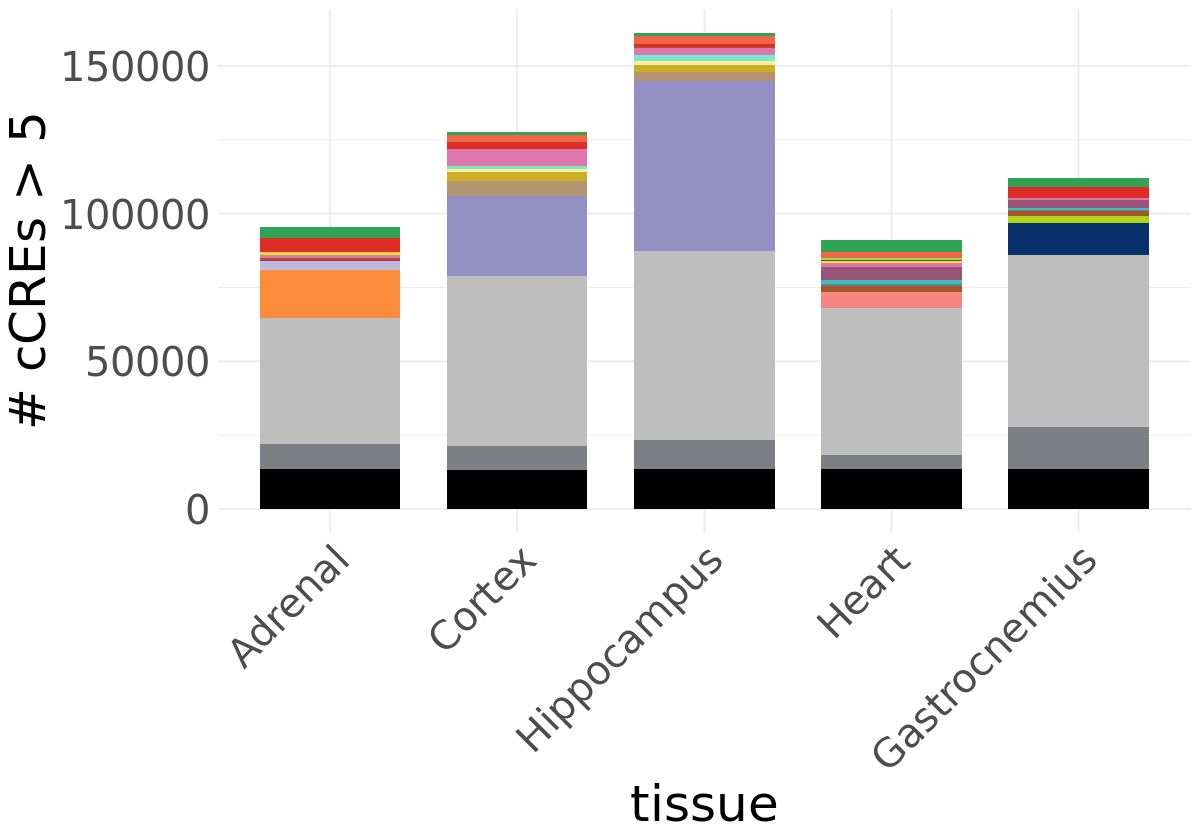

In [43]:
ccre_breakdown_all_tissues_plot = ccre_breakdown_all_tissues_final

annot_cols = read.csv("../snrna/ref/enc4_mouse_snrna_celltypes.csv")

temp = unique(annot_cols[,colnames(annot_cols) %in% c(level, color_level)])
temp = temp[temp[[level]] %in% ccre_breakdown_all_tissues_plot$group,]
temp = rbind(temp, c("Shared","grey"))
temp = rbind(temp, c("General","#7e7f84"))
temp = rbind(temp, c("Global","black"))

table(ccre_breakdown_all_tissues_plot$group %in% temp[[level]])

ccre_breakdown_all_tissues_plot$group = as.character(ccre_breakdown_all_tissues_plot$group)
ccre_breakdown_all_tissues_plot$group[!(ccre_breakdown_all_tissues_plot$group %in% temp[[level]])]

celltype_palette = temp[[color_level]]
names(celltype_palette) = temp[[level]]

ccre_breakdown_all_tissues_plot$group = factor(ccre_breakdown_all_tissues_plot$group, 
                                              levels = unique(names(celltype_palette)))
ccre_breakdown_all_tissues_plot$tissue = str_to_title(ccre_breakdown_all_tissues_plot$tissue)
ccre_breakdown_all_tissues_plot$tissue = factor(ccre_breakdown_all_tissues_plot$tissue,
                                           levels = c("Adrenal", "Cortex", "Hippocampus", "Heart", "Gastrocnemius"))
    
options(repr.plot.width = 10, repr.plot.height = 7)


ggplot(ccre_breakdown_all_tissues_plot, aes(x = tissue, y = n_ccres_rpm_cutoff, fill = group)) +
  geom_bar(stat = "identity", width = 0.75) +
  theme_minimal()  + scale_fill_manual(values = celltype_palette) + 
  theme(text = element_text(size=30)) +
  ylab(paste0("# cCREs > ", rpm_cutoff)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))& NoLegend()

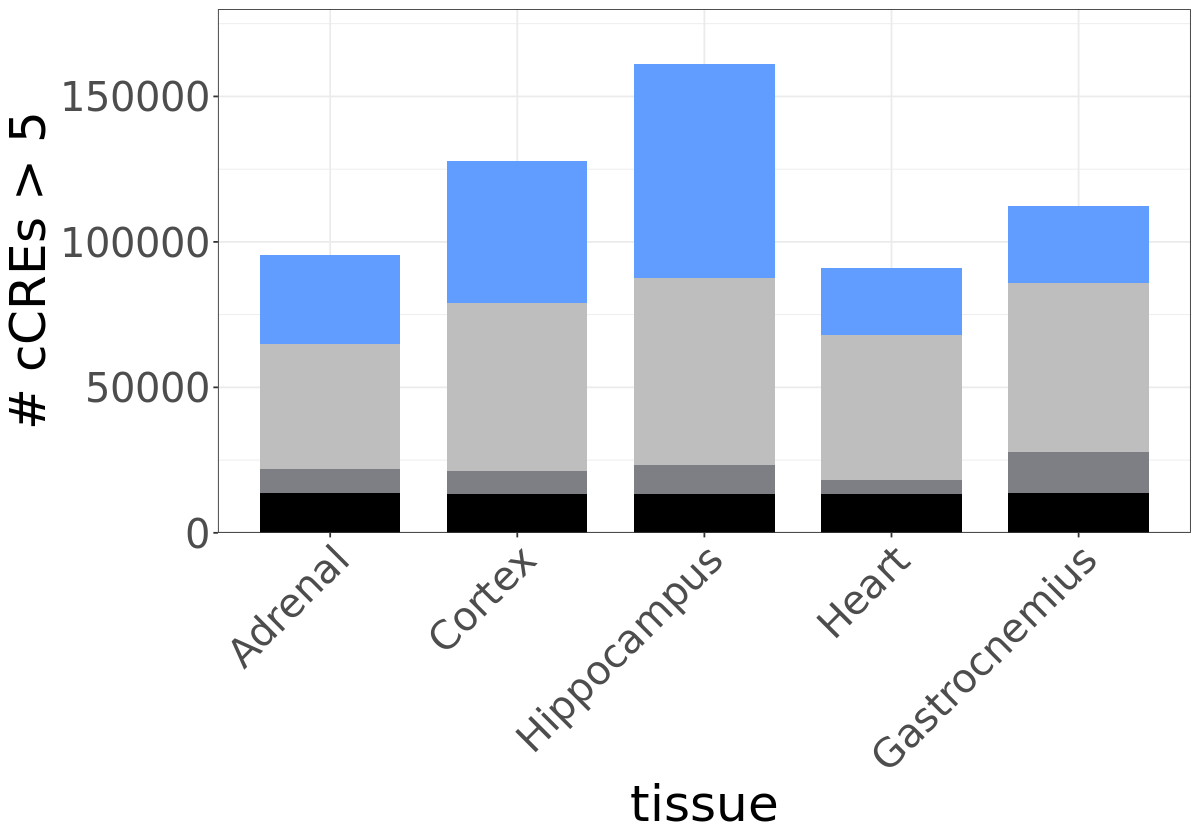

In [46]:
ccre_breakdown_all_tissues_plot_v2 = ccre_breakdown_all_tissues_final

ccre_breakdown_all_tissues_plot_v2[!(ccre_breakdown_all_tissues_plot_v2$group %in% c("Shared","General","Global")),"group"] = "Specific"

ccre_breakdown_all_tissues_plot_v2$tissue = str_to_title(ccre_breakdown_all_tissues_plot_v2$tissue)
ccre_breakdown_all_tissues_plot_v2$tissue = factor(ccre_breakdown_all_tissues_plot_v2$tissue,
                                           levels = c("Adrenal", "Cortex", "Hippocampus", "Heart", "Gastrocnemius"))
ccre_breakdown_all_tissues_plot_v2$group = factor(ccre_breakdown_all_tissues_plot_v2$group, levels = c("Specific","Shared","General","Global"))


options(repr.plot.width = 10, repr.plot.height = 7)


ggplot(ccre_breakdown_all_tissues_plot_v2, aes(x = tissue, y = n_ccres_rpm_cutoff, fill = group)) +
  geom_bar(stat = "identity", width = 0.75) +
  theme_bw()  + scale_fill_manual(values = c("#619cff","grey","#7e7f84","black"))  + 
  theme(text = element_text(size=30)) +
  ylab(paste0("# cCREs > ", rpm_cutoff)) + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
  scale_y_continuous(expand = c(0, 0), limits = c(0, 180000))& NoLegend()


In [47]:
sum(ccre_breakdown_all_tissues_plot_v2[ccre_breakdown_all_tissues_plot_v2$tissue == "Adrenal",]$n_ccres_rpm_cutoff)
sum(ccre_breakdown_all_tissues_plot_v2[ccre_breakdown_all_tissues_plot_v2$tissue == "Cortex",]$n_ccres_rpm_cutoff)
sum(ccre_breakdown_all_tissues_plot_v2[ccre_breakdown_all_tissues_plot_v2$tissue == "Hippocampus",]$n_ccres_rpm_cutoff)
sum(ccre_breakdown_all_tissues_plot_v2[ccre_breakdown_all_tissues_plot_v2$tissue == "Heart",]$n_ccres_rpm_cutoff)
sum(ccre_breakdown_all_tissues_plot_v2[ccre_breakdown_all_tissues_plot_v2$tissue == "Gastrocnemius",]$n_ccres_rpm_cutoff)



[1] 95514

[1] 127766

[1] 161164

[1] 91056

[1] 112187

# Fig. 4c-e

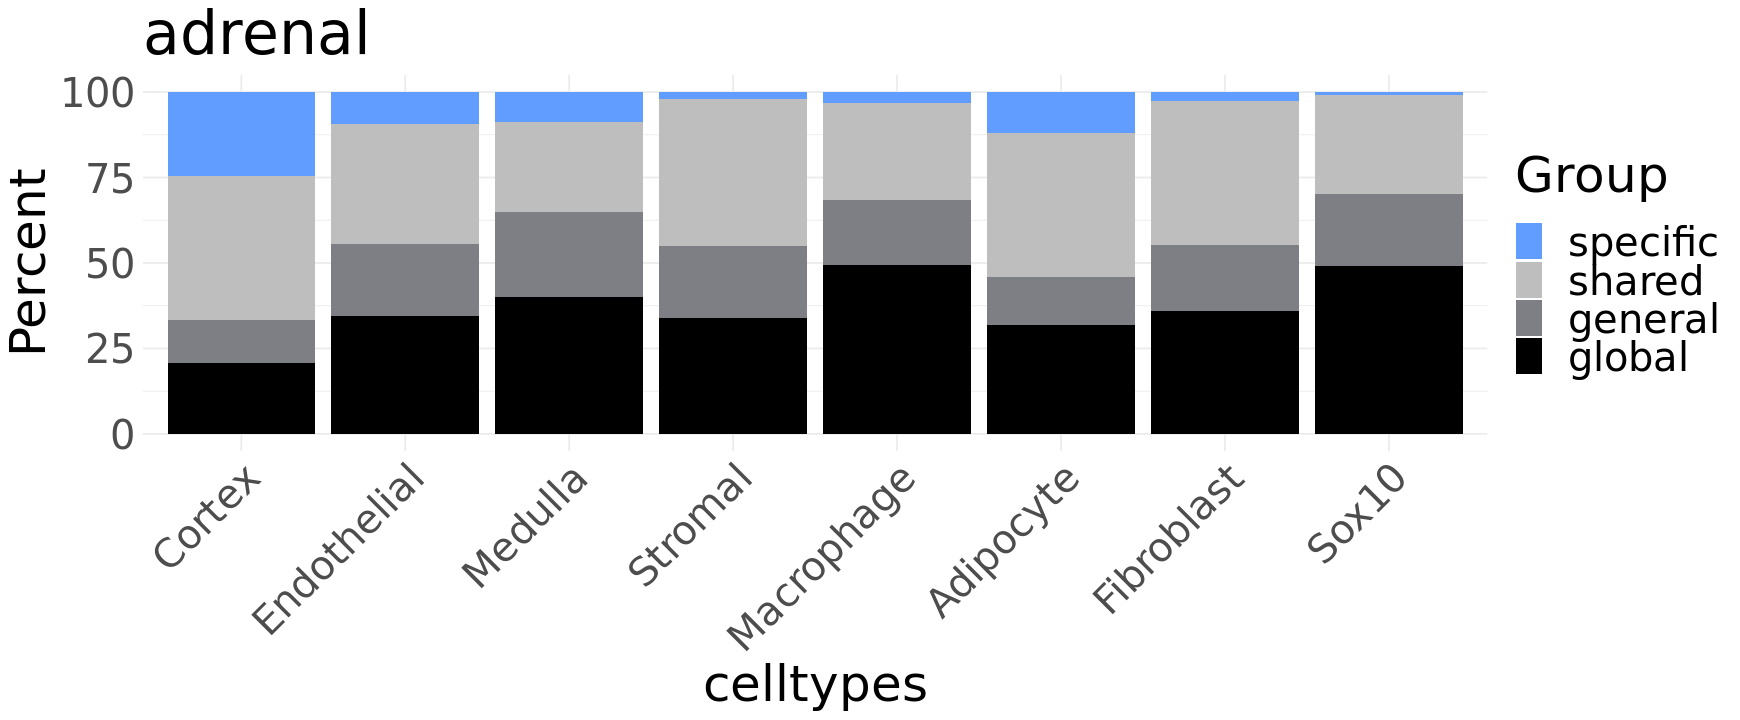

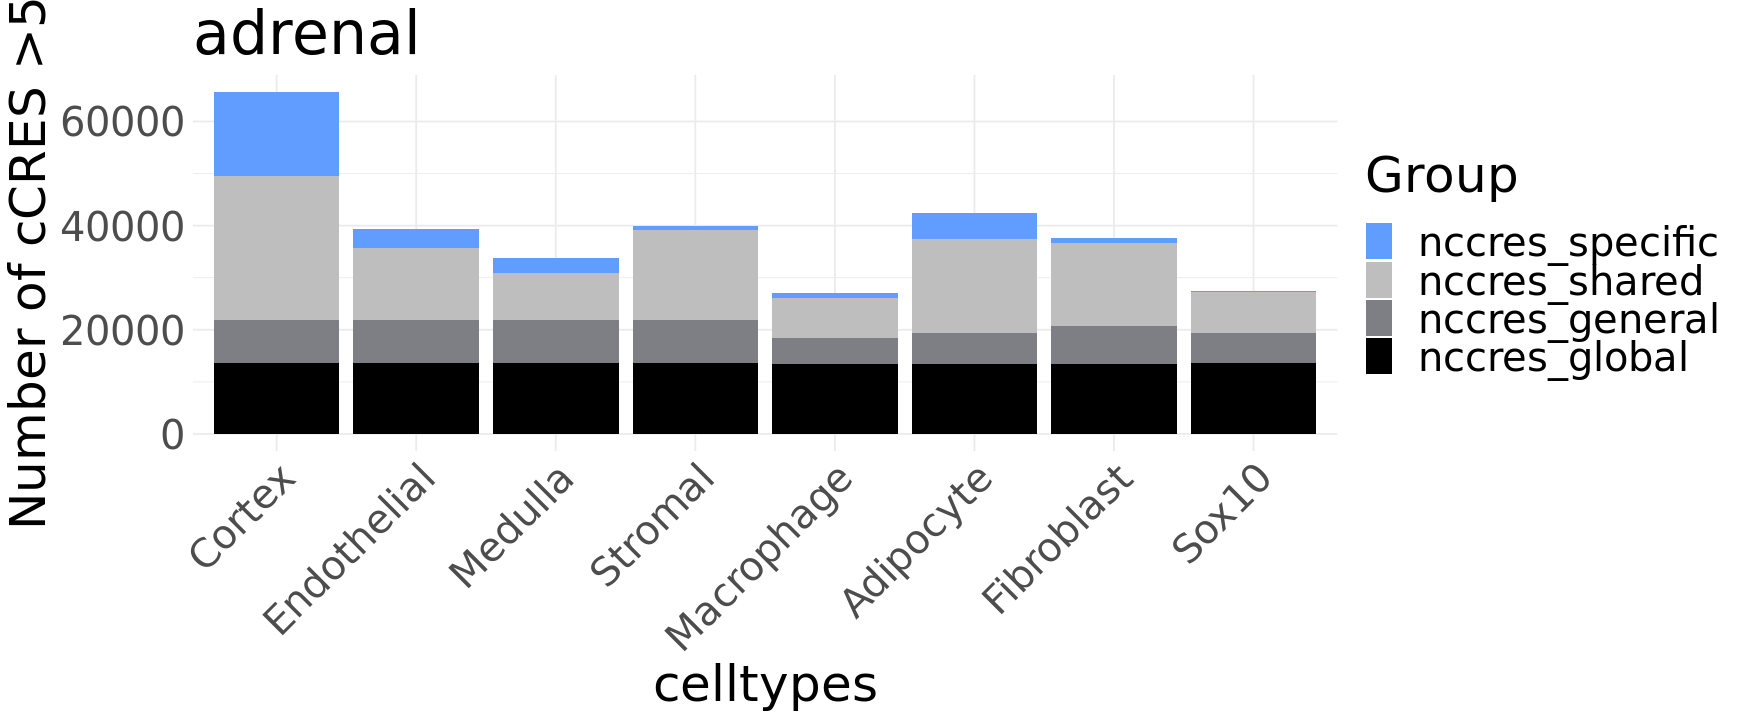

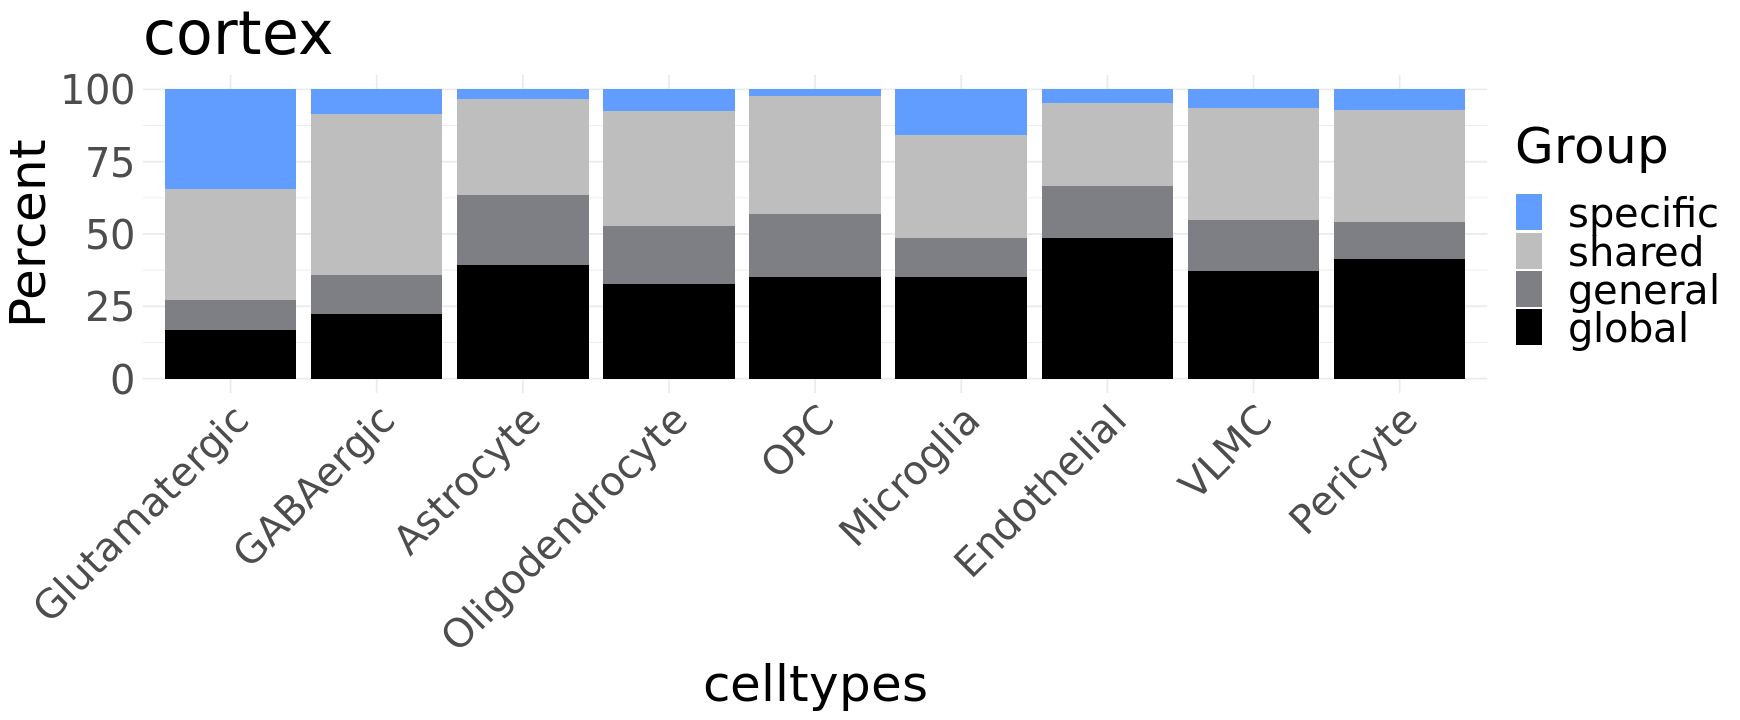

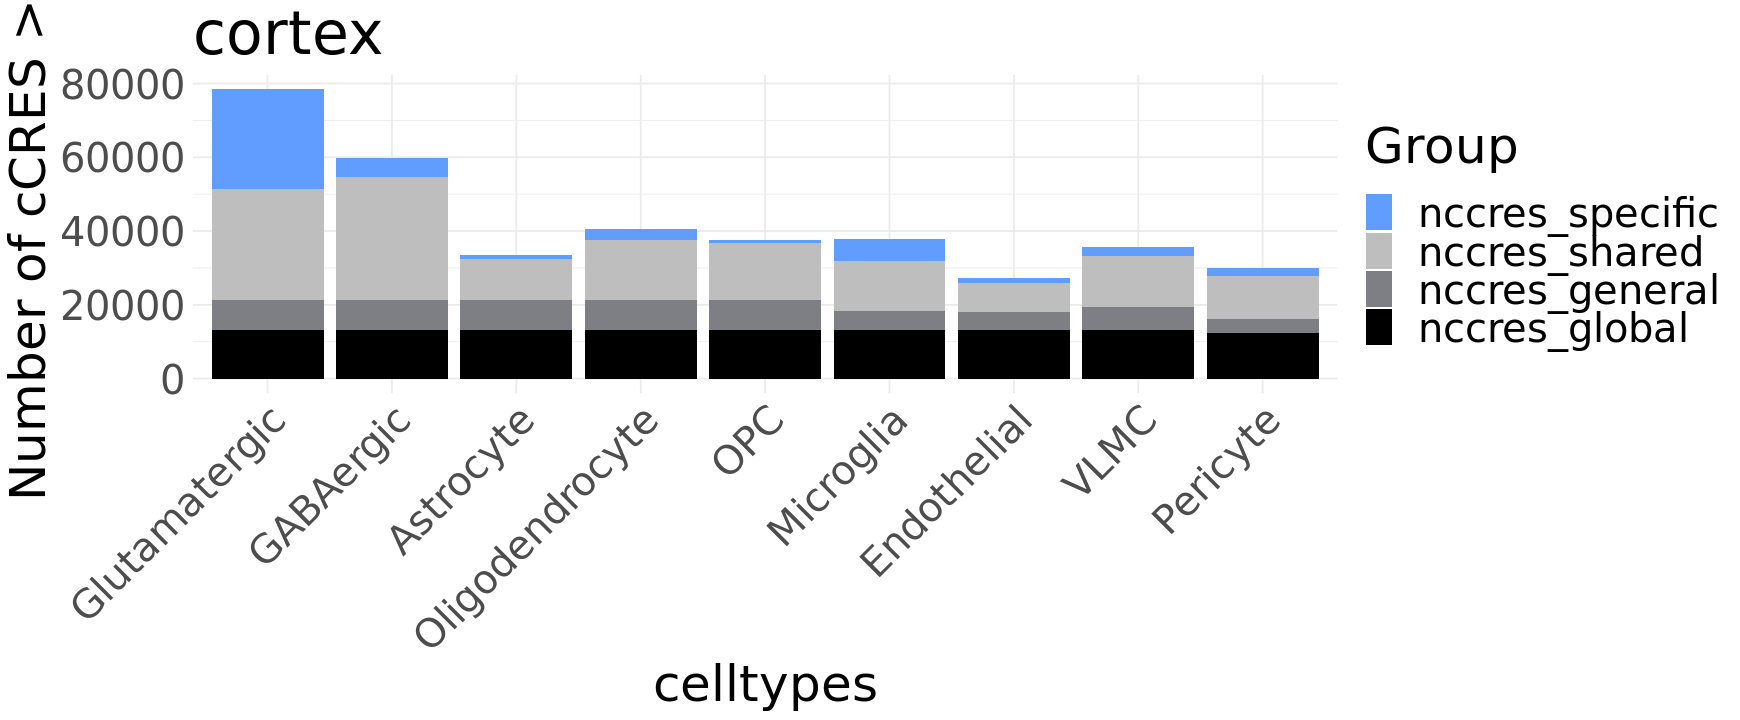

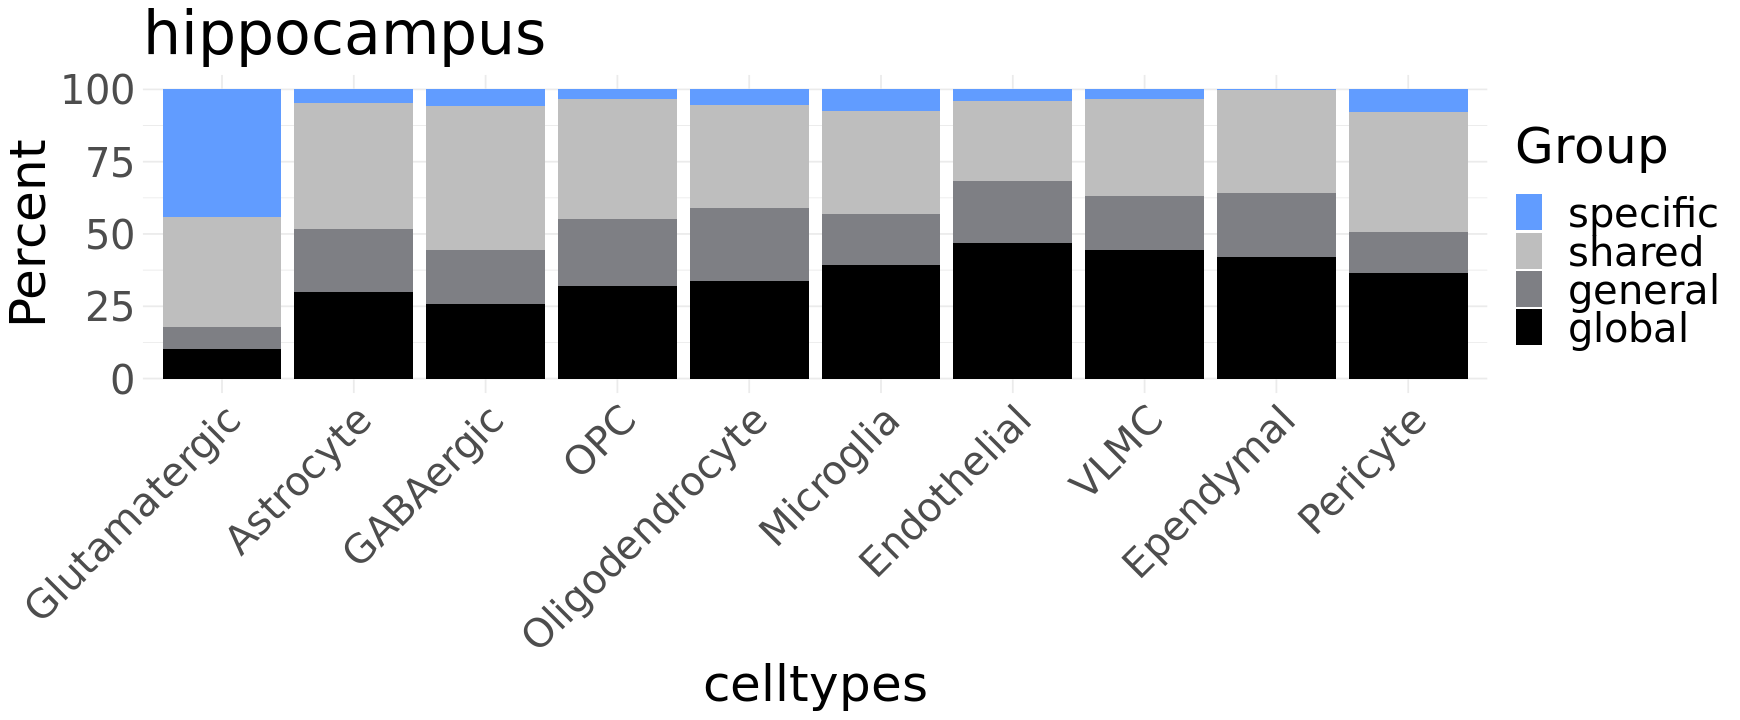

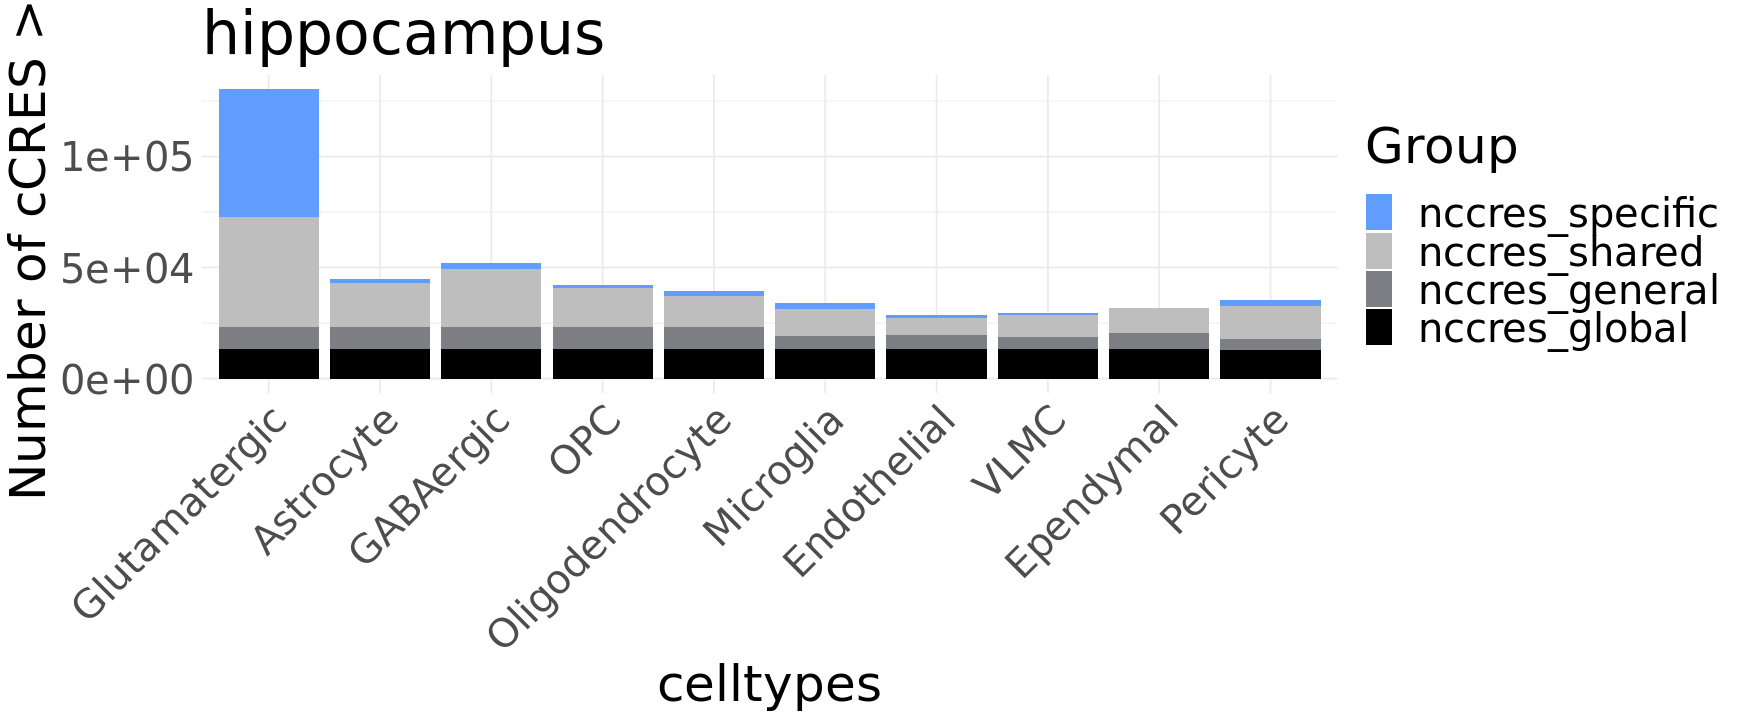

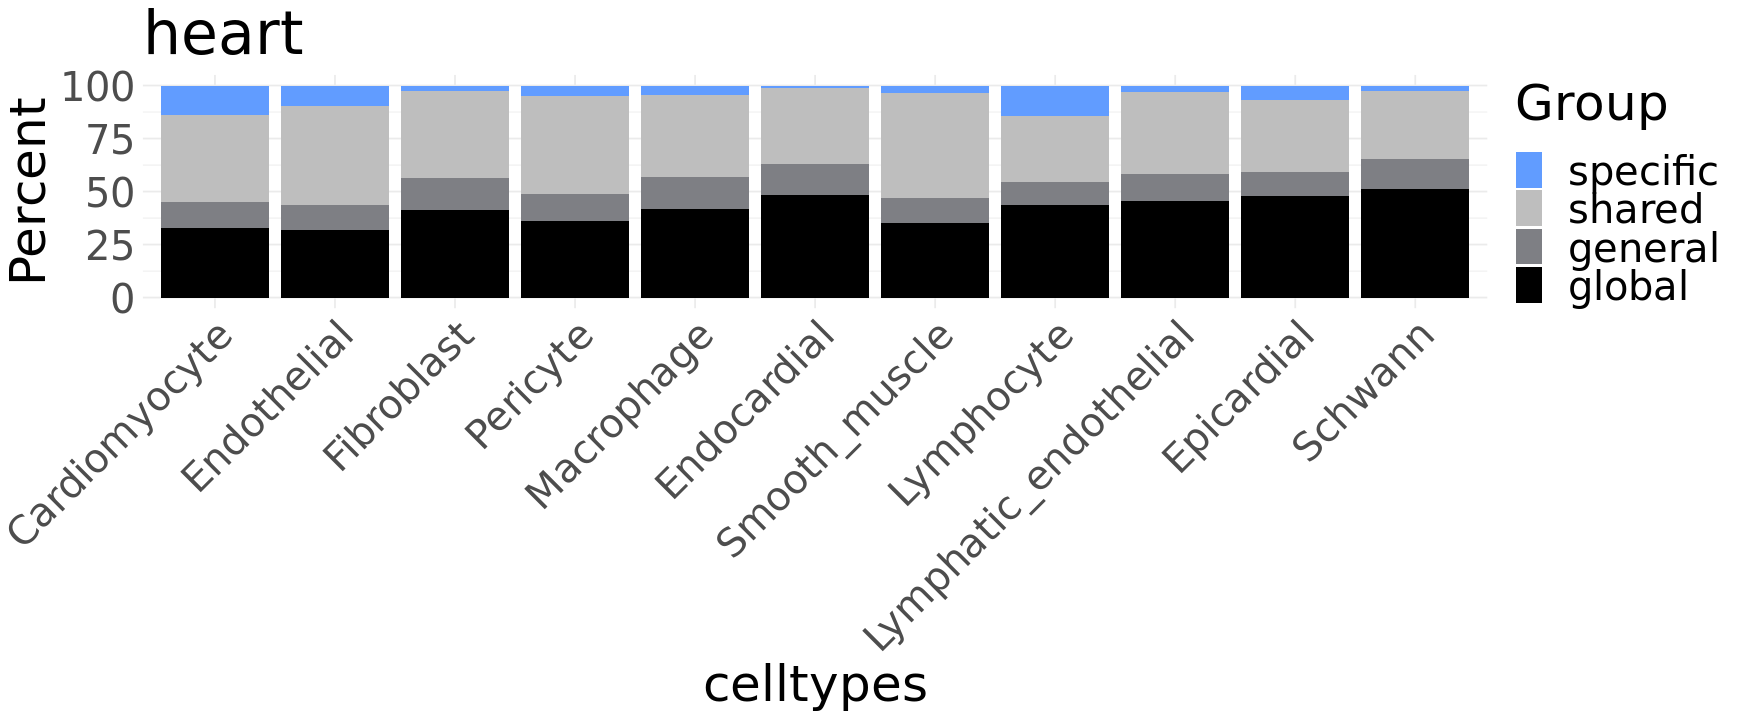

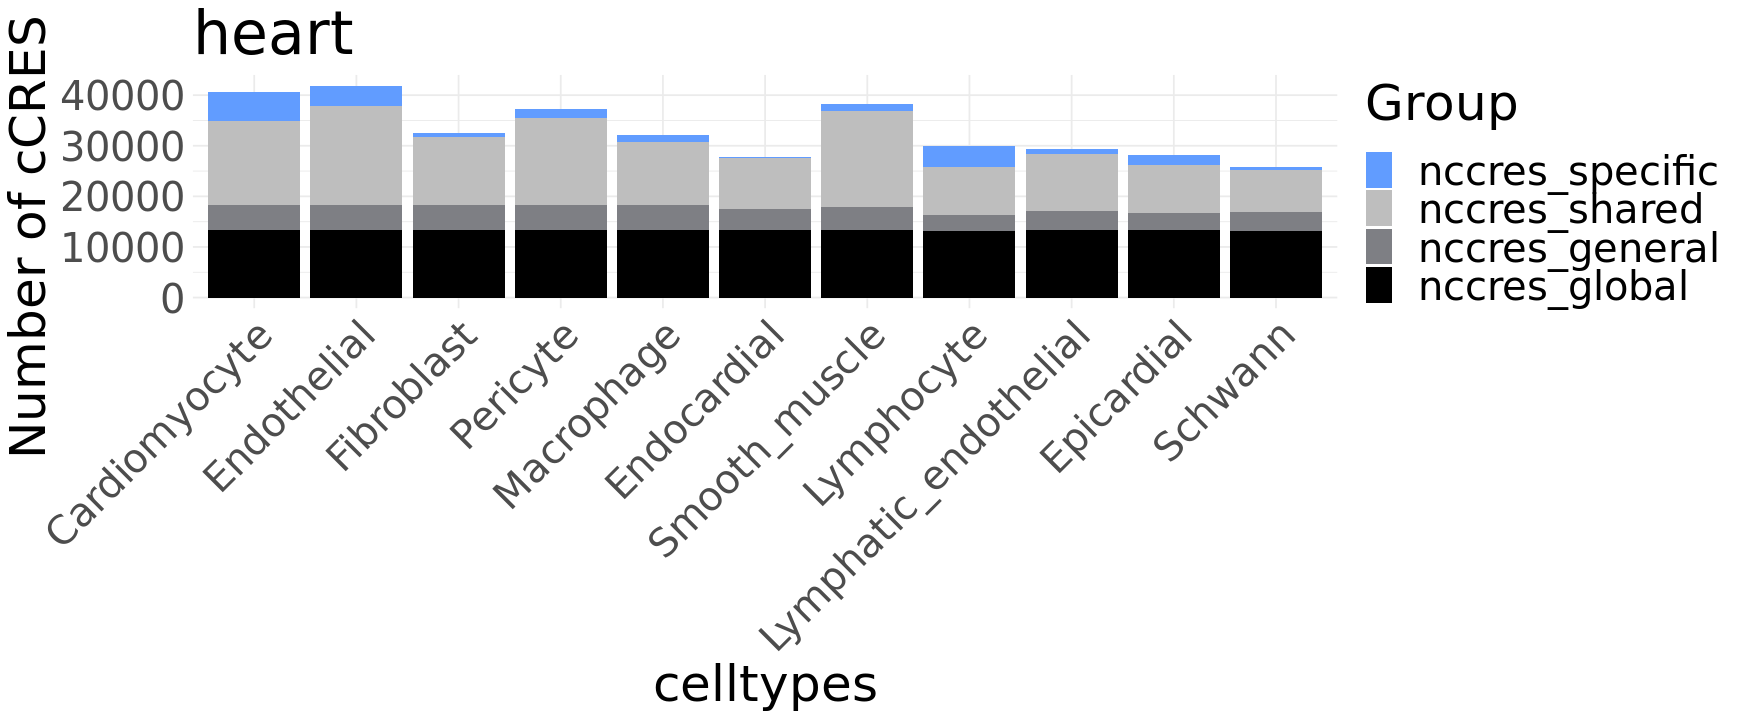

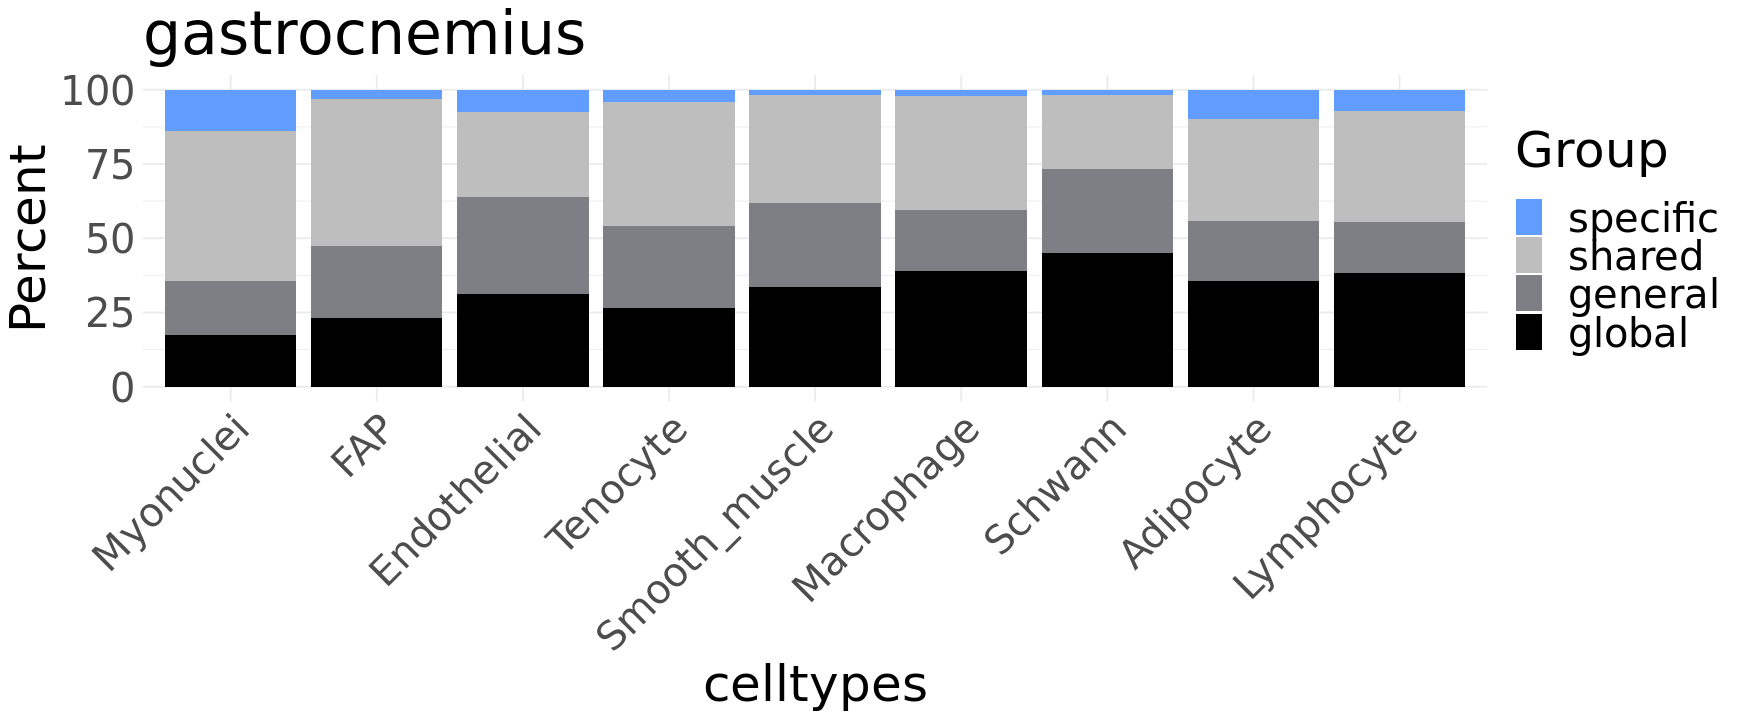

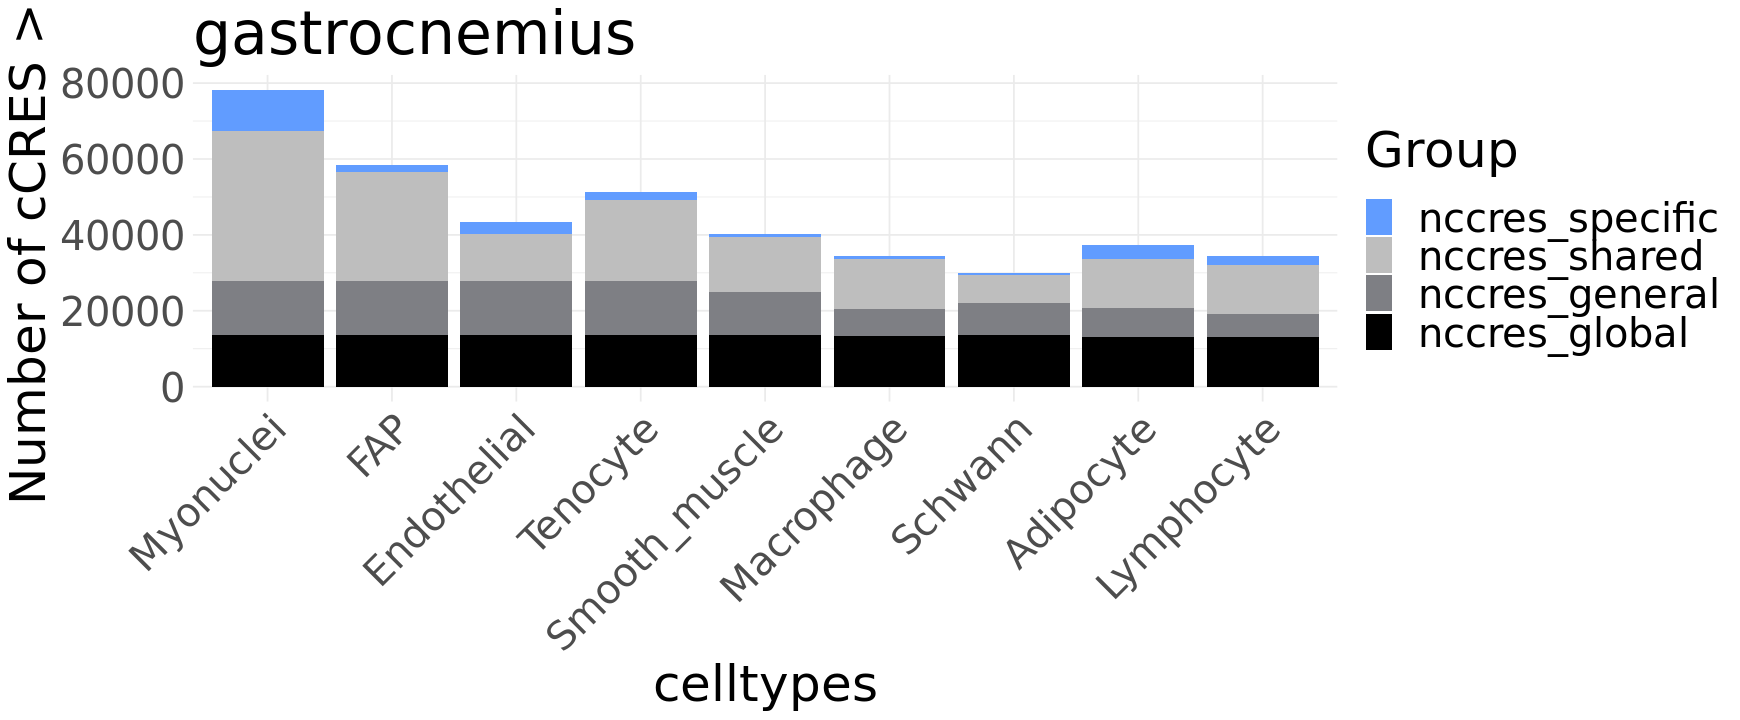

In [48]:
for (tissue in tissues){
    specific = specific_ccre_list_final[[tissue]]
    shared = shared_ccre_list_final[[tissue]]
    general = general_ccre_list_final[[tissue]]
    global = global_ccre_list_final[[tissue]]

    specific = data.frame(colSums(specific))
    colnames(specific) = "nccres_specific"
    specific$celltype = rownames(specific)
    #print(specific)

    shared = data.frame(colSums(shared))
    colnames(shared) = "nccres_shared"
    shared$celltype = rownames(shared)
    #print(shared)

    general = data.frame(colSums(general))
    colnames(general) = "nccres_general"
    general$celltype = rownames(general)
    #print(general)
    
    global = data.frame(colSums(global))
    colnames(global) = "nccres_global"
    global$celltype = rownames(global)
    #print(global)
    

    total_ccres = left_join(specific, shared, by = "celltype")
    total_ccres = left_join(total_ccres, general, by = "celltype")
    total_ccres = left_join(total_ccres, global, by = "celltype")
    total_ccres$sum = rowSums(total_ccres[, c("nccres_specific", "nccres_shared", "nccres_general","nccres_global")])

    total_ccres$specific = (total_ccres$nccres_specific / total_ccres$sum)*100
    total_ccres$shared = (total_ccres$nccres_shared / total_ccres$sum)*100
    total_ccres$general = (total_ccres$nccres_general / total_ccres$sum)*100
    total_ccres$global = (total_ccres$nccres_global / total_ccres$sum)*100

    total_ccres_long_pct = total_ccres %>%
        gather(key = "group", value = "percent", 
        specific, shared, general, global)
    
    total_ccres_long_nccres = total_ccres %>%
        gather(key = "group", value = "nccres", 
        nccres_specific, nccres_shared, nccres_general,nccres_global)


    total_ccres_long_pct$group = factor(total_ccres_long_pct$group, 
                                           levels = c("specific","shared","general","global"))
    total_ccres_long_nccres$group = factor(total_ccres_long_nccres$group, 
                                           levels = c("nccres_specific","nccres_shared","nccres_general","nccres_global"))
    
    options(repr.plot.width = 14.5, repr.plot.height = 6)
    

    total_ccres_long_pct$celltype = factor(total_ccres_long_pct$celltype, 
                                           levels = ncells_per_group_list[[tissue]]$group)
    total_ccres_long_nccres$celltype = factor(total_ccres_long_nccres$celltype, 
                                           levels = ncells_per_group_list[[tissue]]$group)

    total_ccres_long_pct$celltype = factor(total_ccres_long_pct$celltype, 
                                           levels = ncells_per_group_list[[tissue]]$group)
    total_ccres_long_nccres$celltype = factor(total_ccres_long_nccres$celltype, 
                                           levels = ncells_per_group_list[[tissue]]$group)

    #print(total_ccres)
    print(ggplot(total_ccres_long_pct, aes(x = celltype, y = percent, fill = group)) +
        geom_bar(stat = "identity", position = "stack") +
        labs(x = "celltype", y = "Percent", fill = "Group") +
        theme_minimal()+ xlab(level) +
        theme(text = element_text(size=30)) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_fill_manual(values = c("#619cff","grey","#7e7f84","black"))+ ggtitle(tissue)) 
    
    
    print(ggplot(total_ccres_long_nccres, aes(x = celltype, y = nccres, fill = group)) +
        geom_bar(stat = "identity", position = "stack") +
        labs(x = "celltype", y = paste0("Number of cCRES >",rpm_cutoff), fill = "Group") +
        theme_minimal() + xlab(level) +
        theme(text = element_text(size=30)) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        scale_fill_manual(values = c("#619cff","grey","#7e7f84","black"))+ ggtitle(tissue))


}


[1] 34859
[1] 63978


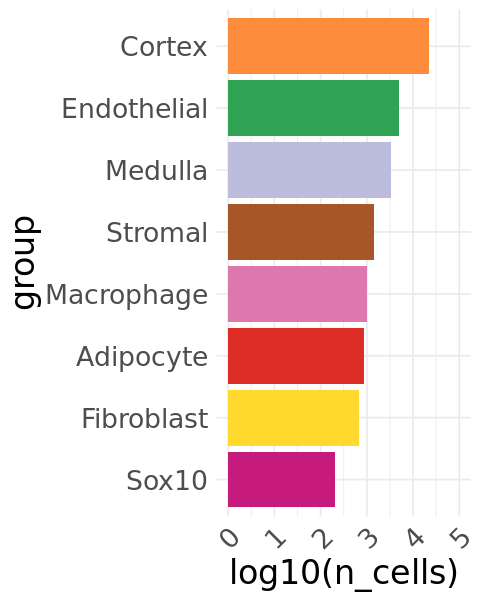

[1] 36222


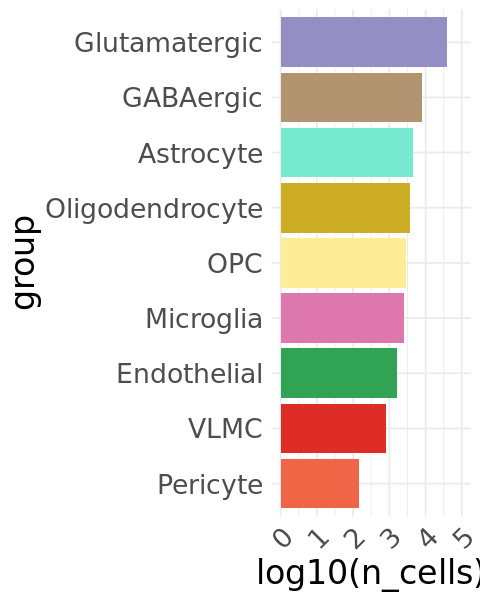

[1] 58828


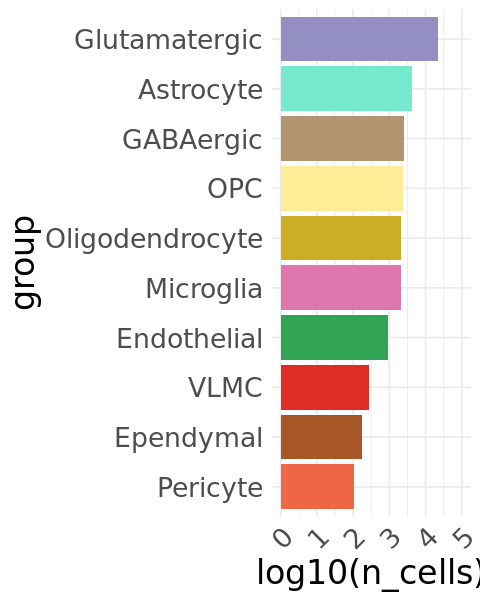

[1] 42934


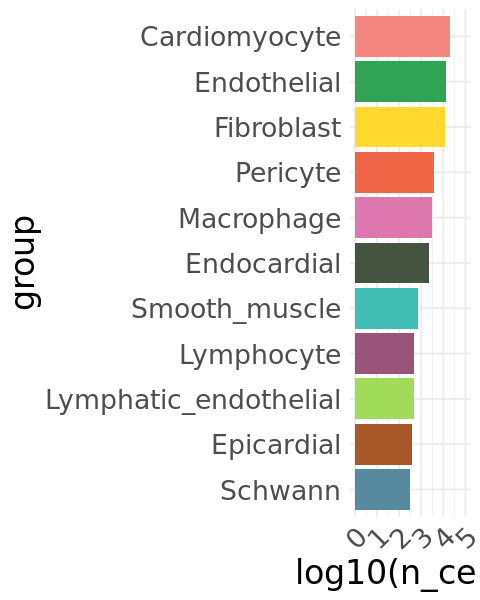

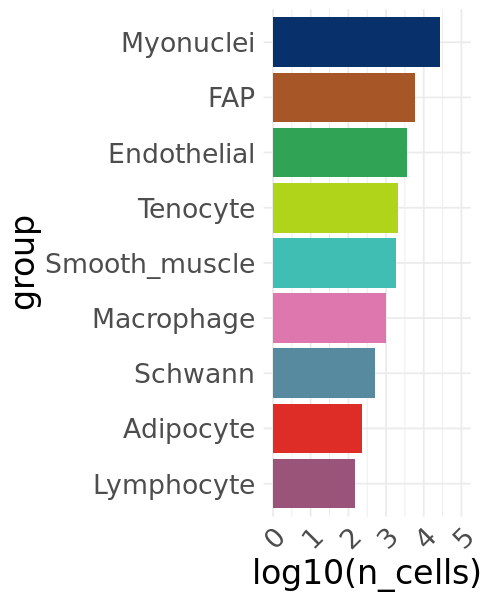

In [55]:
options(repr.plot.width = 4, repr.plot.height = 5)

for(tissue in tissues){
    
    plot_ncells= ncells_per_group_list[[tissue]]
    plot_ncells = plot_ncells[plot_ncells$n_cells > min_cells,]
    print(sum(plot_ncells$n_cells))
    plot_ncells$group = factor(plot_ncells$group, 
                               levels = rev(plot_ncells$group))
    
    print(ggplot(plot_ncells, aes(x = log10(n_cells), y = group, fill = group)) + 
          geom_bar(stat = "identity")+
          theme_minimal() + scale_fill_manual(values = celltype_palette) + 
          theme(axis.text.x = element_text(angle = 45, hjust = 1))+
          theme(text = element_text(size=20))+ 
          # theme(panel.grid.major.x = element_line(color = "black",
          #                               linewidth = 0.5))+
          xlim(0,5) + NoLegend()) 
}